In [34]:
import pandas as pd
import matplotlib.pyplot as plt


table_SC = pd.read_excel('data/RiodoRasto_Formation_Database_attPedro.xlsx', sheet_name='SC')
table_PR = pd.read_excel('data/RiodoRasto_Formation_Database_attPedro.xlsx', sheet_name='PR')


table_SC = table_SC.drop(columns=['system', 'body_thickness', 'bar_thickness', 'storey_thickness', 'no_stories'])
table_PR = table_PR.drop(columns=['system', 'body_thickness', 'bar_thickness', 'storey_thickness', 'no_stories'])



In [35]:
def classification_grain_size_SC(row):
    if row['grain_size'] <= 0.06:
        return 0 # Fines
    elif row['grain_size'] >= 0.125 and row['grain_size'] <=1.0:
        return 1 # Sandstone
    elif row['grain_size'] >= 2.0:
        return 2 # Conglomerate
    
table_SC['classification_grain_size'] = table_SC.apply(classification_grain_size_SC, axis=1)
table_PR['classification_grain_size'] = table_PR.apply(classification_grain_size_SC, axis=1)
table_SC


table_SC = table_SC.fillna(0)
table_PR = table_PR.fillna(0)

table_SC.loc[table_SC['facies'].str.startswith('Hw'), 'facies'] = 'Hw'
table_PR.loc[table_PR['facies'].str.startswith('Hw'), 'facies'] = 'Hw'

k_means_table_SC = table_SC[['grain_size','classification_grain_size']]
k_means_table_SC


,grain_size,classification_grain_size
0,0.004,0.0
1,0.060,0.0
2,0.004,0.0
3,0.004,0.0
4,0.004,0.0
...,...,...
443,0.060,0.0
444,0.060,0.0
445,0.125,1.0
446,0.125,1.0


/home/ph_silva/UFSC/miniconda3/envs/coastsat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_115788/789085120.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_means_table_SC['cluster'] = kmeans.fit_predict(X_scaled)
/tmp/ipykernel_115788/789085120.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

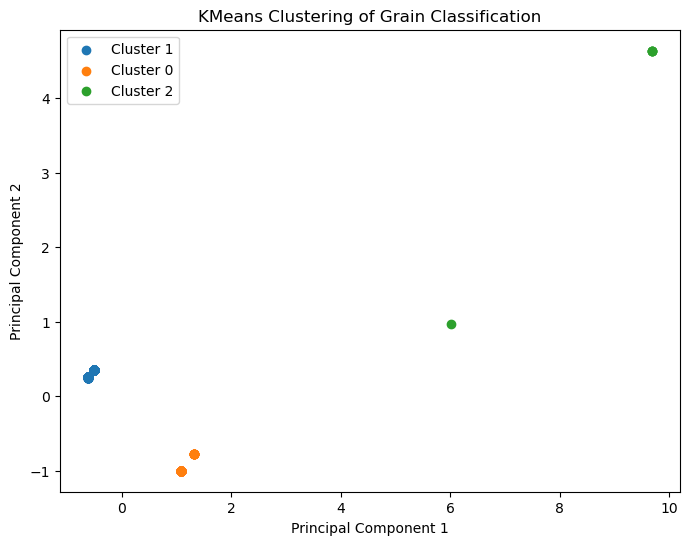

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


#Selecionar as colunas para o treinamento do KMeans
X = k_means_table_SC[['classification_grain_size', 'grain_size']]
k_means_table_SC
#Padronizar os dados para que as unidades não influenciem o algoritmo KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar o algoritmo KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
k_means_table_SC['cluster'] = kmeans.fit_predict(X_scaled)

# Reduzir a dimensionalidade para visualização
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Adicionar os resultados do KMeans ao DataFrame
k_means_table_SC['cluster'] = kmeans.labels_
k_means_table_SC['pca1'] = X_pca[:, 0]
k_means_table_SC['pca2'] = X_pca[:, 1]

# Plotar os resultados
plt.figure(figsize=(8, 6))
for cluster in k_means_table_SC['cluster'].unique():
    plt.scatter(k_means_table_SC[k_means_table_SC['cluster'] == cluster]['pca1'],
                k_means_table_SC[k_means_table_SC['cluster'] == cluster]['pca2'],
                label=f'Cluster {cluster}')

plt.title('KMeans Clustering of Grain Classification')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

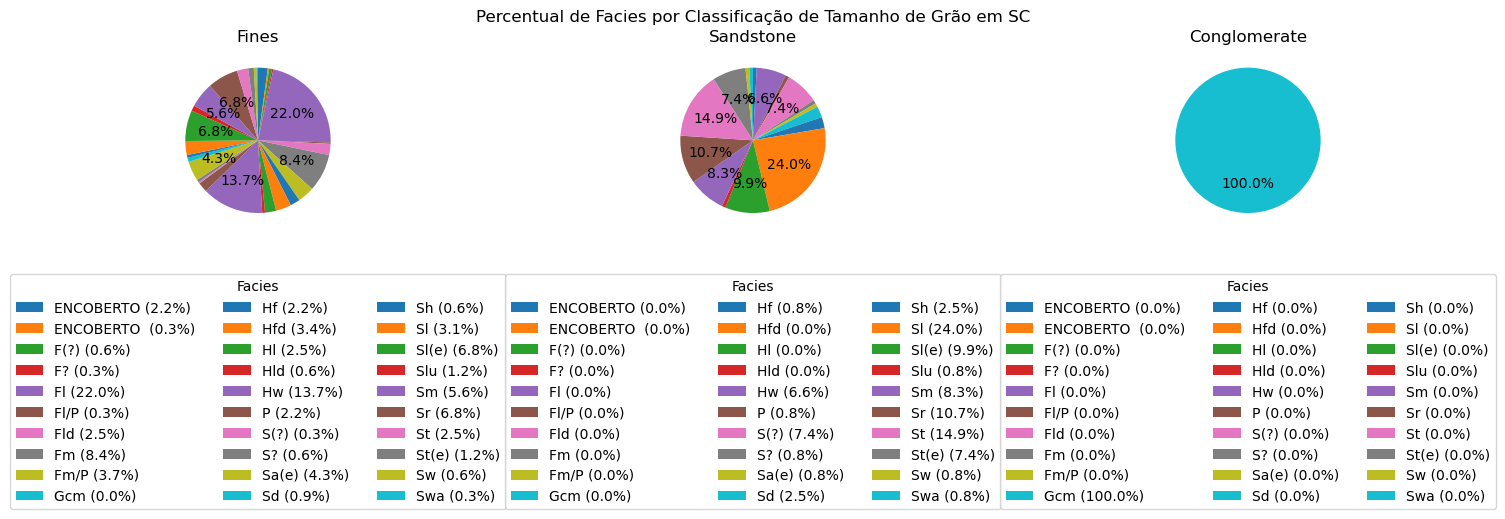

In [50]:
import matplotlib.pyplot as plt

# Agrupar os dados
grouped = table_SC.groupby(['classification_grain_size', 'facies']).size().unstack()

# Calcular o percentual para cada facies
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

grouped_percentage = grouped_percentage.fillna(0)

# Criar gráficos de pizza
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

facies_labels = ['Fines', 'Sandstone', 'Conglomerate']

for i, ax in enumerate(axes):
    wedges, texts, autotexts = ax.pie(grouped_percentage.iloc[i], labels=None, autopct=lambda p: f'{p:.1f}%' if p >= 4 else '', startangle=90, counterclock=False)

    # Adicionar percentual ao lado de cada item da legenda
    legend_labels = [f'{label} ({p:.1f}%)' if p >= 0 else label for label, p in zip(grouped_percentage.columns, grouped_percentage.iloc[i])]
    
    # Adicionar legenda abaixo do gráfico
    ax.legend(wedges, legend_labels, title='Facies', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

    ax.set_title(f'{facies_labels[i]}')

# Ajustar layout para evitar sobreposição
plt.tight_layout()

plt.suptitle('Percentual de Facies por Classificação de Tamanho de Grão em SC', y=1.05)
plt.show()


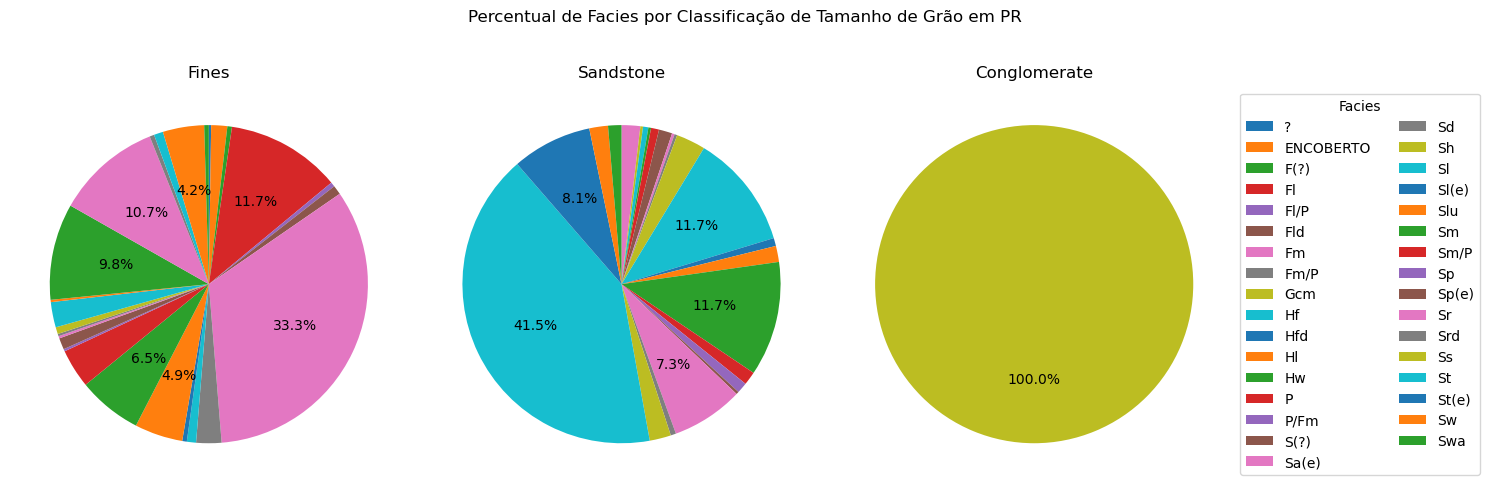

In [37]:
# Agrupar os dados
grouped_2 = table_PR.groupby(['classification_grain_size', 'facies']).size().unstack()

# Calcular o percentual para cada facies
grouped_percentage_PR = grouped_2.div(grouped.sum(axis=1), axis=0) * 100

grouped_percentage_PR = grouped_percentage_PR.fillna(0)
# Criar gráficos de pizza
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

facies_labels = ['Fines', 'Sandstone', 'Conglomerate']

legend_handles = []

for i, ax in enumerate(axes):
    wedges, texts, autotexts = ax.pie(grouped_percentage_PR.iloc[i], labels=None, autopct=lambda p: f'{p:.1f}%' if p >= 4 else '', startangle=90, counterclock=False)
    
    if any(p >= 4 for p in grouped_percentage_PR.iloc[i]):
        legend_handles.extend(wedges)

    ax.set_title(f'{facies_labels[i]}')

# Adicionar legenda fora do loop
plt.legend(legend_handles, grouped_percentage_PR.columns, title='Facies', loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

plt.suptitle('Percentual de Facies por Classificação de Tamanho de Grão em PR', y=1.05)
plt.show()

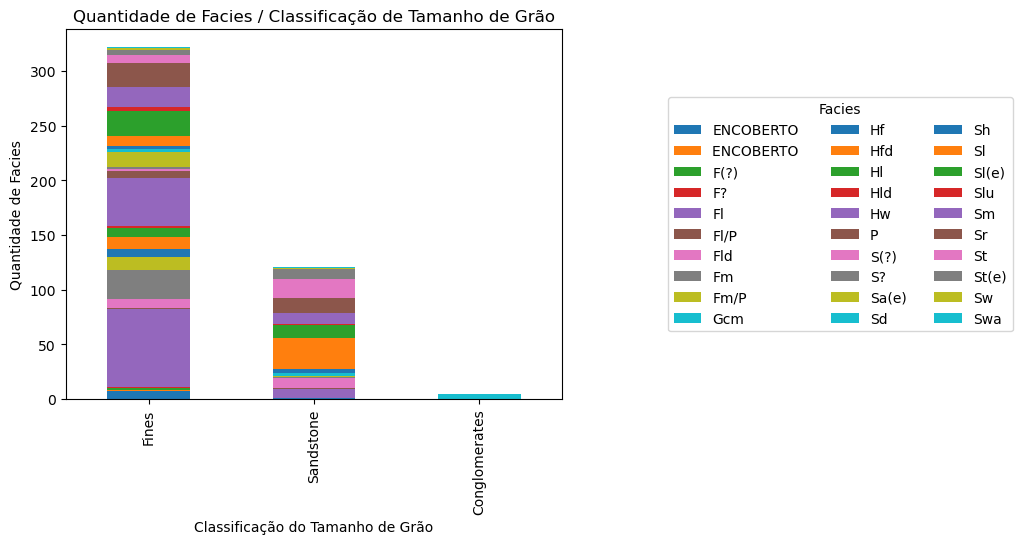

In [10]:
grouped = table_SC.groupby(['classification_grain_size', 'facies']).size().unstack()

ax = grouped.plot(kind='bar', stacked=True)

plt.xlabel('Classificação do Tamanho de Grão')
plt.ylabel('Quantidade de Facies')
plt.title('Quantidade de Facies / Classificação de Tamanho de Grão')

legend_title = 'Facies' 

cluster_labels = {0: 'Fines', 1: 'Sandstone', 2: 'Conglomerates'}
ax.set_xticklabels([cluster_labels[i] for i in grouped.index])
ax.legend(title=legend_title, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=3)

# for i, col in enumerate(grouped.columns):
#     for j, val in enumerate(grouped[col]):
#         percent = val / grouped[col].sum() * 100
#         ax.text(i, grouped[col][:j].sum() + val / 2, f'{percent:.1f}%', ha='center', va='center')


#plt.tight_layout()
plt.show()

/home/ph_silva/UFSC/miniconda3/envs/coastsat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


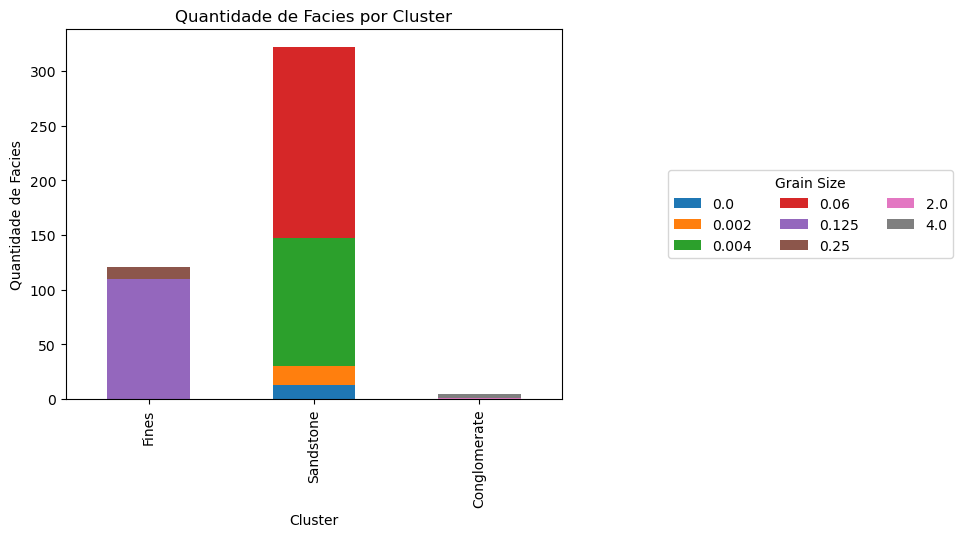

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Selecionar as colunas relevantes
data_for_kmeans = table_SC[['grain_size', 'classification_grain_size']]
data_for_kmeans = data_for_kmeans.fillna(0)

# Normalizar os dados
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_for_kmeans)

# Escolher o número de clusters (ajuste conforme necessário)
num_clusters = 3

# Aplicar o k-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
table_SC['cluster'] = kmeans.fit_predict(normalized_data)

# Visualizar os resultados
grouped = table_SC.groupby(['cluster', 'grain_size']).size().unstack()
ax = grouped.plot(kind='bar', stacked=True)

plt.xlabel('Cluster')
plt.ylabel('Quantidade de Facies')
plt.title('Quantidade de Facies por Cluster')
legend_title = 'Grain Size'
ax.legend(title=legend_title, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=3)

# Substituir as legendas do eixo x pelos rótulos desejados
cluster_labels = {0: 'Fines', 1: 'Sandstone', 2: 'Conglomerate'}
ax.set_xticklabels([cluster_labels[i] for i in grouped.index])

plt.show()


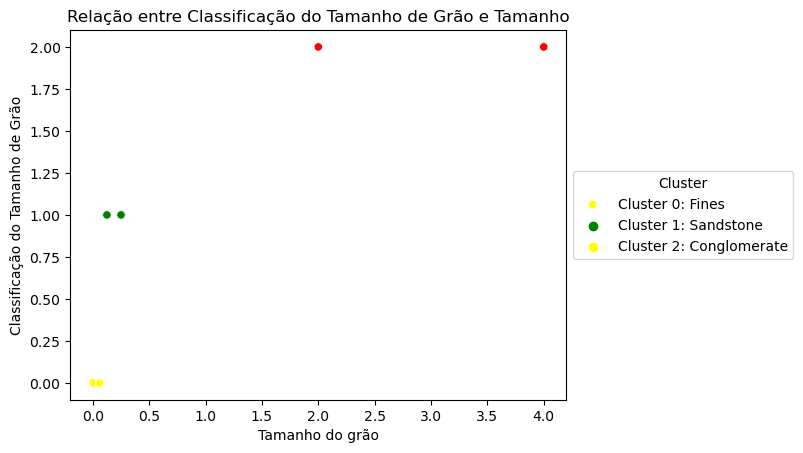

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Scatter plot colorido por cluster
scatter = sns.scatterplot(x='grain_size', y='classification_grain_size', hue='cluster', data=table_SC, palette={0: 'green', 1: 'yellow', 2: 'red'})

cluster_labels = {0: 'Fines', 1: 'Sandstone', 2: 'Conglomerate'}

plt.xlabel('Tamanho do grão')
plt.ylabel('Classificação do Tamanho de Grão')
plt.title('Relação entre Classificação do Tamanho de Grão e Tamanho')

scatter.legend(title='Cluster', labels=[f'Cluster {i}: {cluster_labels[i]}' for i in range(len(cluster_labels))], loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.show()


In [9]:
import numpy as np
from sklearn.cluster import KMeans

# Converter a tabela grouped em uma matriz numpy
data = grouped.fillna(0)

grouped
# Criar o objeto KMeans com o número desejado de clusters
kmeans = KMeans(n_clusters=3)

# # Executar o algoritmo K-means
kmeans.fit(data)

# # Obter os rótulos dos clusters para cada ponto
labels = kmeans.labels_
grouped.columns


# # Adicionar os rótulos dos clusters como uma nova coluna na tabela grouped
# grouped['cluster'] = labels

# # Plotar o gráfico de barras com os clusters coloridos
# ax = grouped.plot(kind='bar', stacked=True, x='facies', y='cluster')

# plt.xlabel('Classificação do Tamanho de Grão')
# plt.ylabel('Cluster')
# plt.title('Clusterização das Facies por Classificação de Tamanho de Grão')

# legend_title = 'Facies'

# ax.legend(title=legend_title, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=3)

# plt.show()


/home/ph_silva/UFSC/miniconda3/envs/coastsat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Index(['Gcm', 'F(?)', 'F?', 'Fl', 'Fl/P', 'Fld', 'Fm', 'Fm/P', 'Hf', 'Hfd',
       'Hl', 'Hld', 'Hw/Fl', 'Hw/Fm', 'Hw/S?', 'Hw/Sm', 'Hw/Sr', 'Hw/Sw',
       'Hwd/Fm', 'Hwd/Fmd', 'Hwd/Sm', 'Hwd/Sr', 'Hwd/Srd', 'Hwd/Sw', 'P',
       'S(?)', 'S?', 'Sa(e)', 'Sd', 'Sh', 'Sl', 'Sl(e)', 'Slu', 'Sm', 'Sr',
       'St', 'St(e)', 'Sw', 'Swa'],
      dtype='object', name='facies')

In [8]:
grouped.to_excel('data/SC_classification_grain_size.xlsx')

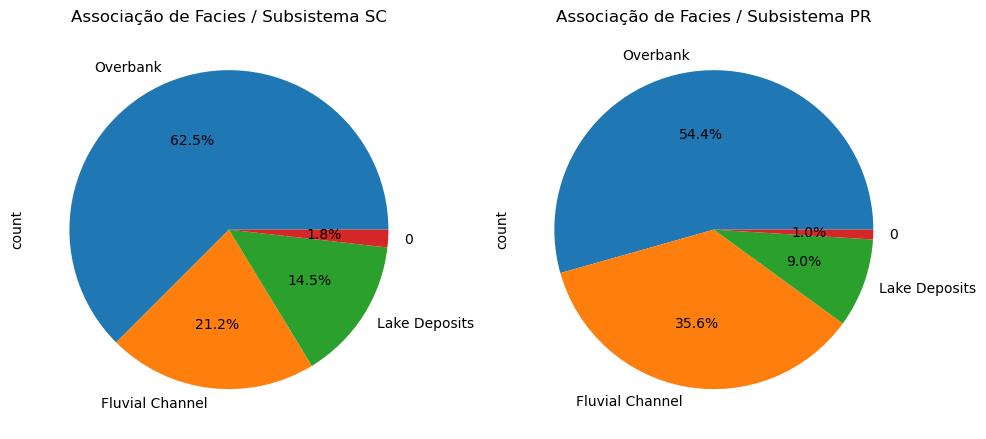

In [9]:
grouped_sc = table_SC['subsystem'].value_counts()
grouped_pr = table_PR['subsystem'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


grouped_sc.plot.pie(ax=ax1, autopct='%1.1f%%')
ax1.set_title('Associação de Facies / Subsistema SC')

grouped_pr.plot.pie(ax=ax2, autopct='%1.1f%%')
ax2.set_title('Associação de Facies / Subsistema PR')

plt.tight_layout()
plt.show()

/home/ph_silva/UFSC/miniconda3/envs/coastsat/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyError: 'cluster'

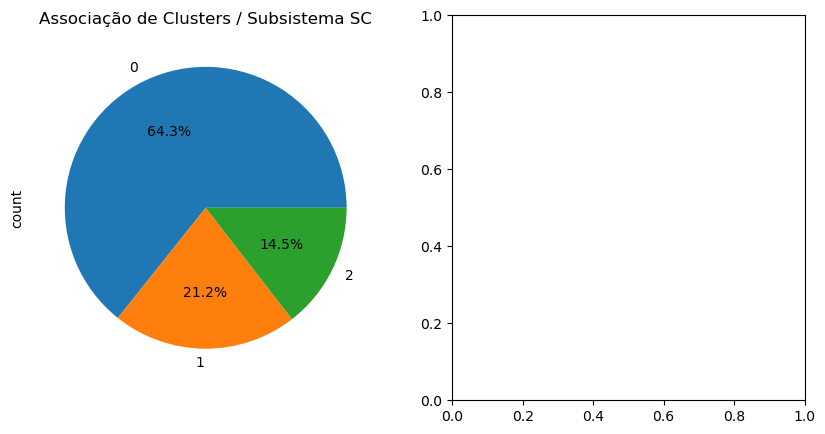

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Suponha que você tenha um DataFrame chamado 'table' com as colunas relevantes
# Vamos usar apenas 'subsystem' para a geração do cluster neste exemplo

# Criar um DataFrame contendo apenas a coluna 'subsystem'
subsystem_data = pd.DataFrame(table_SC['subsystem'])

# Converter dados categóricos em variáveis dummy (one-hot encoding)
subsystem_encoded = pd.get_dummies(subsystem_data, prefix='subsystem_encoded')

# Normalizar os dados
scaler = StandardScaler()
normalized_data = scaler.fit_transform(subsystem_encoded)

# Escolher o número de clusters
num_clusters = 3  # Ajuste conforme necessário

# Aplicar o K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
subsystem_data['cluster'] = kmeans.fit_predict(normalized_data)

# Adicionar a coluna 'cluster' ao DataFrame original
table_SC['cluster'] = subsystem_data['cluster']

# Visualizar os resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Gráfico de pizza para SC
grouped_sc = table_SC['cluster'].value_counts()
grouped_sc.plot.pie(ax=ax1, autopct='%1.1f%%')
ax1.set_title('Associação de Clusters / Subsistema SC')

#Você pode repetir o processo para PR se desejar
grouped_pr = table_PR['cluster'].value_counts()
grouped_pr.plot.pie(ax=ax2, autopct='%1.1f%%')
ax2.set_title('Associação de Clusters / Subsistema PR')

plt.tight_layout()
plt.show()


In [14]:
table_SC.columns

Index(['outcrop', 'bed_thickness', 'height_in_succession', 'facies',
       'f_association', 'subsystem', 'grain_size',
       'classification_grain_size'],
      dtype='object')